# AWS Full Stack ML Project - Bike Sharing in Washington DC

This project is based on the a Microsoft online learning module 'Train and evaluate regression models' and a Kaggle competition based on data from the bike sharing system in Washington DC. https://www.kaggle.com/itssuru/bike-sharing-system-washington-dc?select=train_bikes.csv

This notebook is a companion to the slide presentation for the project. It provides pre-processing and analysis of the dataset and pre-testing of several regression models to determine the best for using as a custom model in AWS.

# Problem Statement and Data Analytics
The original problem was to predict the total count of bikes rented during each hour with only prior data. The train set had intervals removed for the test set. Since data analysis showed the day of the month did not impact the count, I simplified and just used the whole training set.

The dataset was collected over 2 years (2011 & 2012) with the following raw features:

> Categorical: datetime(yr-mnth-day-hr), season (1-4), weather (1-4), holiday (0/1), workday (0/1).

> Numerical: temp (C), atemp – apparent temp (C), humidity, windspeed, number of casual and registered renters.

## Relationship of features to count of bikes per hour

> Numerical:  temp & atemp correlate positively, while humidity & windspeed negatively (via scatterplots with feature correlation below). The numbers of casual & registered users is not an indicator of number of rentals.


> Categorical: more rentals in 2012;  month & season similar effects – more rentals in summer & fall; more rentals better weather; more rentals on holidays than not; less rentals on workdays than not (via box plots below.)

## Effect of data update

Retraining would be needed as rentals have greatly increased but the number of samples would remain the same over 2 years.

## Pros and cons of data set

Pros: weather and timing addressed well.

Cons: old dataset and for only 2 years. Missing data on other environmental conditions such as traffic, construction, etc.

This additional data can be collected from government or other agencies to increase value of modeling beyond simple rideshare prediction to effects of city operations and planning on riders.







In [1]:
import pandas as pd

# load the training dataset
bike_data = pd.read_csv('train_bikes.csv')
bike_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [2]:
bike_data.shape

(10886, 12)

## Details of the raw features:

- **datetime**: The date on which the data was observed - in this case, the data was collected hourly; so there's one row per hour.
- **season**: A numerically encoded value indicating the season (1:spring, 2:summer, 3:fall, 4:winter)
- **holiday**: A binary value indicating whether or not the observation was made on a public holiday)
- **workingday**: A binary value indicating whether or not the day is a working day (not a weekend or holiday)
- **weather**: A categorical value indicating the weather situation (1:clear, 2:mist/cloud, 3:light rain/snow, 4:heavy rain/hail/snow/fog)
- **temp**: The temperature in celsius
- **atemp**: The apparent ("feels-like") temperature
- **humidity**: The humidity level
- **windspeed**: The windspeed
- **casual**: The number of non-member riders
- **registered**: The number of member riders
- **count**: The number of bicycle rentals recorded

# Feature Engineering

### Extract data from 'datetime' and remove useless columns

In [3]:
# Extract date and hour data 
import numpy as np

cols = [col for col in bike_data]
bike_data['year'] = pd.DatetimeIndex(bike_data['datetime'], yearfirst=True).year
bike_data['year'] = np.where(bike_data['year']== 2011, 0, 1)
bike_data['month'] = pd.DatetimeIndex(bike_data['datetime'], yearfirst=True).month
bike_data['day'] = pd.DatetimeIndex(bike_data['datetime'], yearfirst=True).day
bike_data['hour'] = pd.DatetimeIndex(bike_data['datetime'], yearfirst=True).hour

In [4]:
# Rearrange columns and drop 'datetime' and useless columns 'casual' and 'registered'
cols = ['year','month','day','hour'] + cols
bike_data = bike_data.reindex(columns=cols)
bike_data = bike_data.drop(columns=['datetime', 'casual', 'registered'])
bike_data.head()

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,1,1,0,1,0,0,1,9.84,14.395,81,0.0,16
1,0,1,1,1,1,0,0,1,9.02,13.635,80,0.0,40
2,0,1,1,2,1,0,0,1,9.02,13.635,80,0.0,32
3,0,1,1,3,1,0,0,1,9.84,14.395,75,0.0,13
4,0,1,1,4,1,0,0,1,9.84,14.395,75,0.0,1


In [5]:
bike_data.shape

(10886, 13)

### Data Statistics

In [6]:
numeric_features = ['temp', 'atemp', 'humidity', 'windspeed']
bike_data[numeric_features + ['count']].describe()

,temp,atemp,humidity,windspeed,count
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,191.574132
std,7.79159,8.474601,19.245033,8.164537,181.144454
min,0.82000,0.760000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,42.000000
50%,20.50000,24.240000,62.000000,12.998000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,284.000000
max,41.00000,45.455000,100.000000,56.996900,977.000000


 The mean number of hourly rentals is about 192 with a comparatively large standard deviation of 181 indicating a lot of variance in the number of rentals per hour. Also the min and max demonstrate a large disparity.

In [7]:
numeric_features

['temp', 'atemp', 'humidity', 'windspeed']

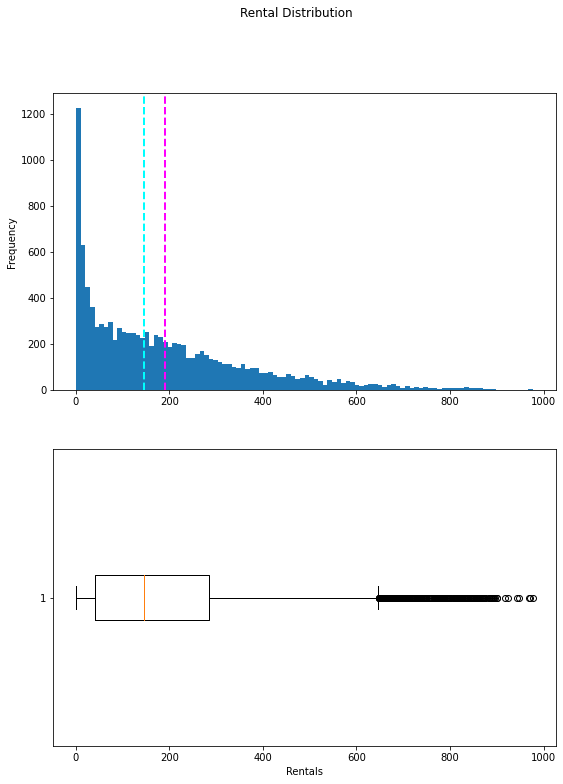

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# This ensures plots are displayed inline in the Jupyter notebook
%matplotlib inline

# Get the label column
label = bike_data['count']


# Create a figure for 2 subplots (2 rows, 1 column)
fig, ax = plt.subplots(2, 1, figsize = (9,12))

# Plot the histogram   
ax[0].hist(label, bins=100)
ax[0].set_ylabel('Frequency')

# Add lines for the mean, median, and mode
ax[0].axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax[0].axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

# Plot the boxplot   
ax[1].boxplot(label, vert=False)
ax[1].set_xlabel('Rentals')

# Add a title to the Figure
fig.suptitle('Rental Distribution')

# Show the figure
fig.show()


Plotting the number of hourly rentals ranges from 0 to close to 1000. However, the mean of 192 number of hourly rentals is closer to the low end of that range, with most of the data between 0 and around 300 rentals and a long tail towards 1000.

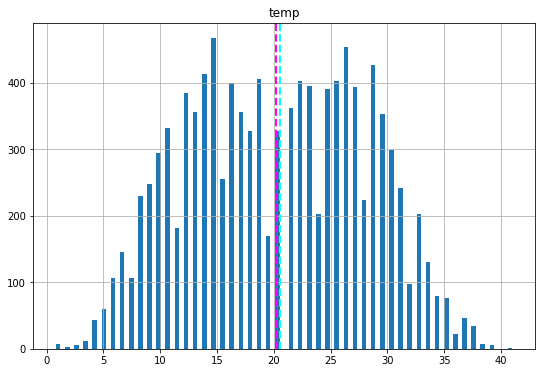

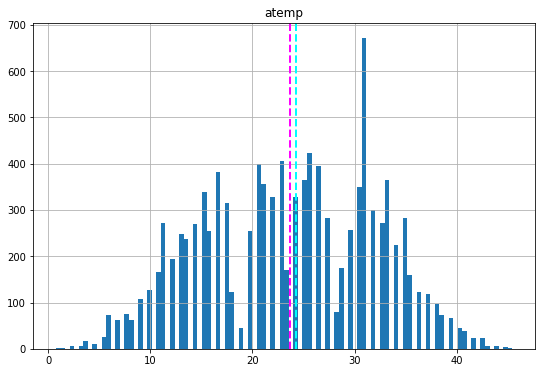

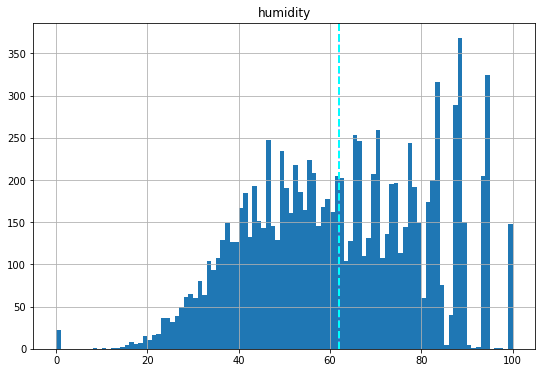

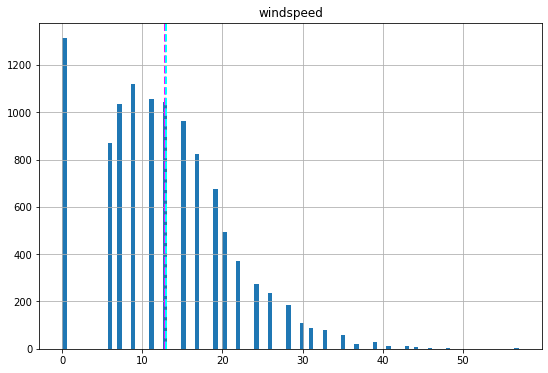

In [9]:
# Plot a histogram for each numeric feature
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

The numeric features show essentially normal distributions. For windspeed this is true around the mean and the large number of no wind (0) samples offsets the long tail of more windy days.

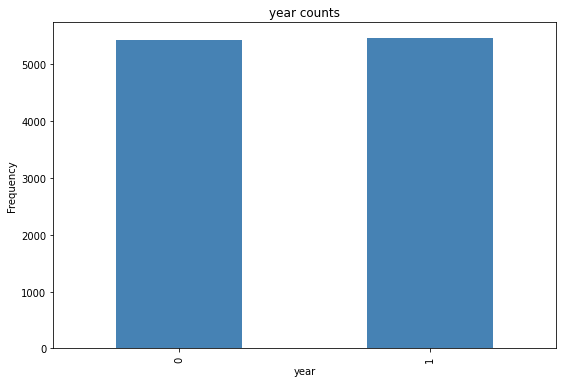

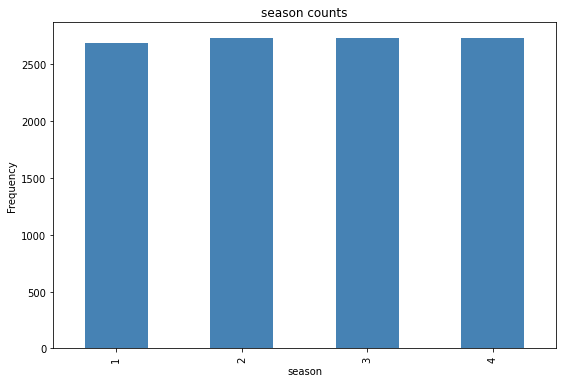

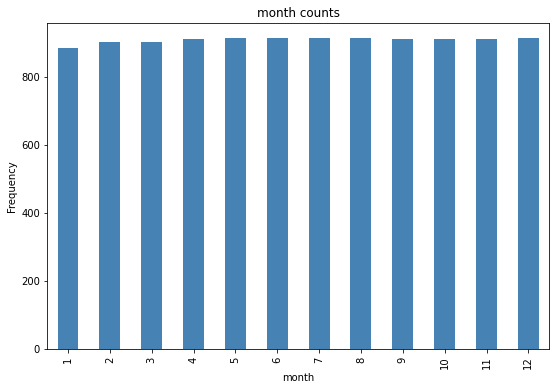

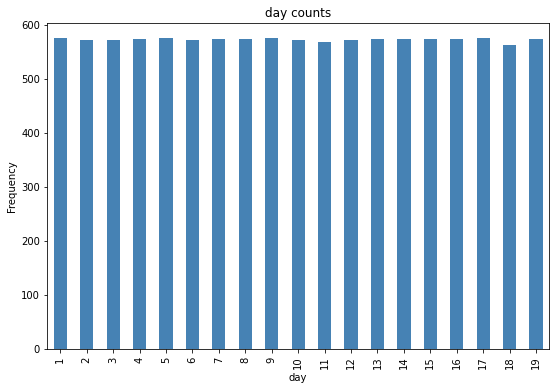

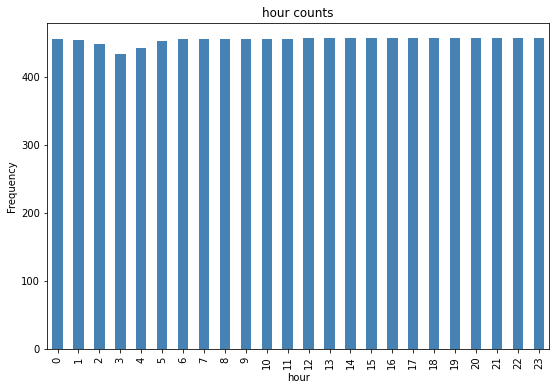

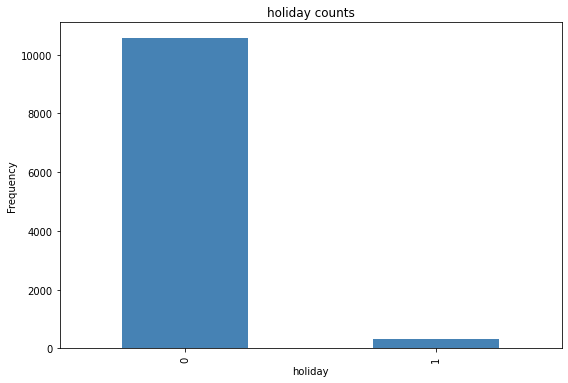

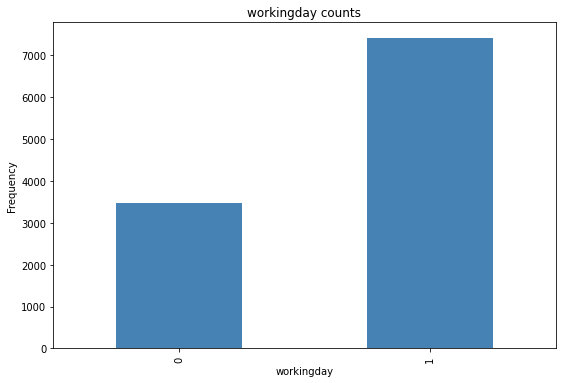

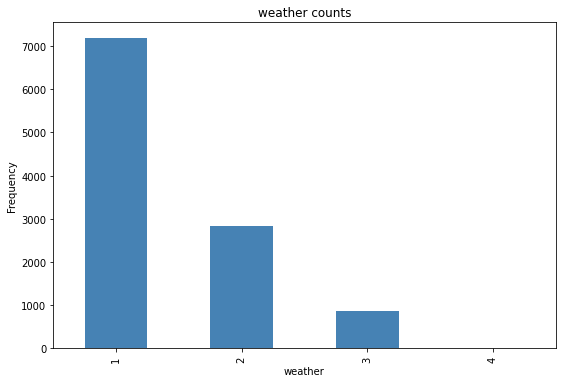

In [10]:
import numpy as np

# plot a bar plot for each categorical feature count
categorical_features = ['year', 'season','month', 'day', 'hour','holiday','workingday','weather']

for col in categorical_features:
    counts = bike_data[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()


Most of the categorical features show a *uniform* distribution except:

- **holiday**: There are many fewer days that are holidays than days that aren't.
- **workingday**: There are more working days than non-working days.
- **weather**: Most days are category *1* (clear), with category *2* (mist and cloud) the next most common. There are comparatively few category *3* (light rain or snow) days, and no category *4* (heavy rain, hail, or fog) days at all.

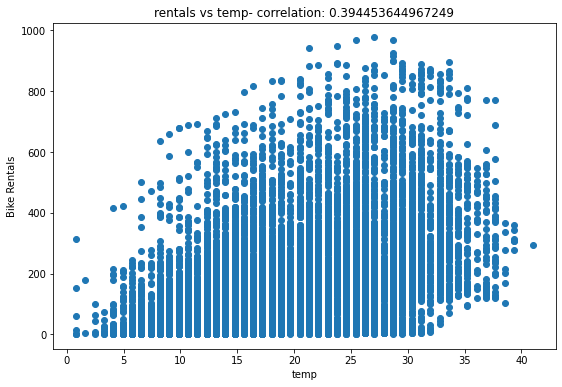

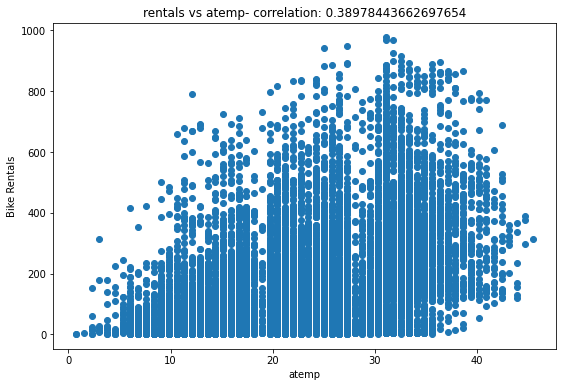

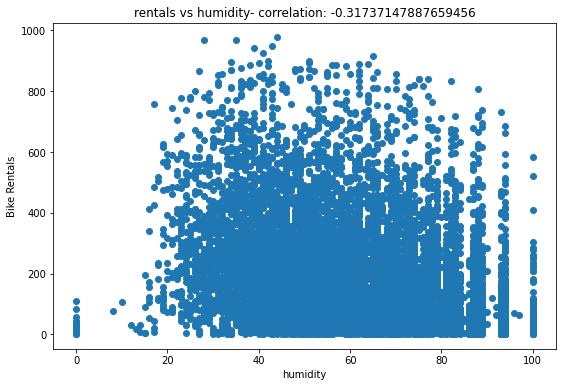

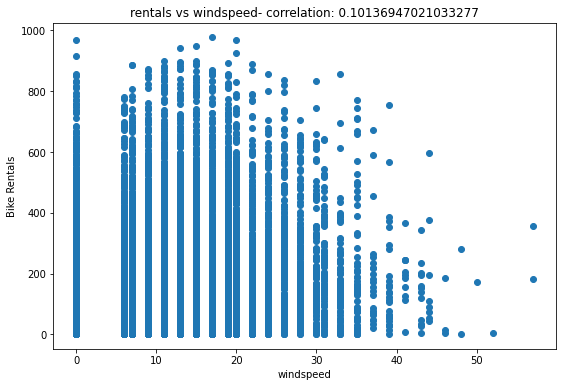

In [11]:
for col in numeric_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = bike_data[col]
    label = bike_data['count']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Bike Rentals')
    ax.set_title('rentals vs ' + col + '- correlation: ' + str(correlation))
plt.show()


Temperature and apparent temperature are positively correlated while humidity is somewhat negative. Windspeed is almost neutral counter to intuition but the large number of days with no to little wind compensates.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

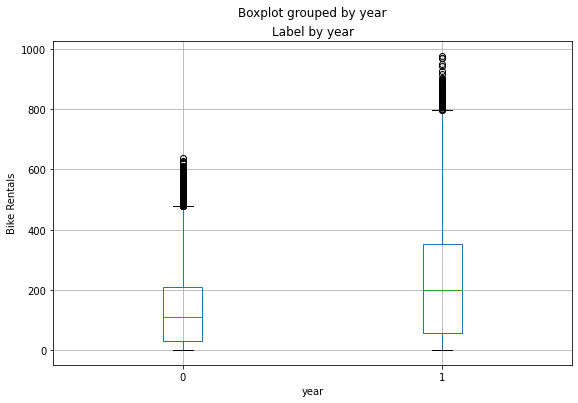

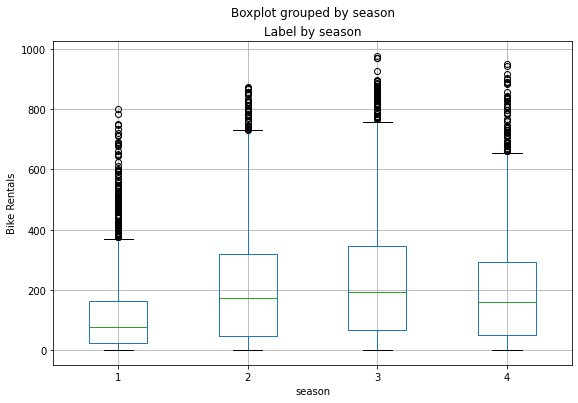

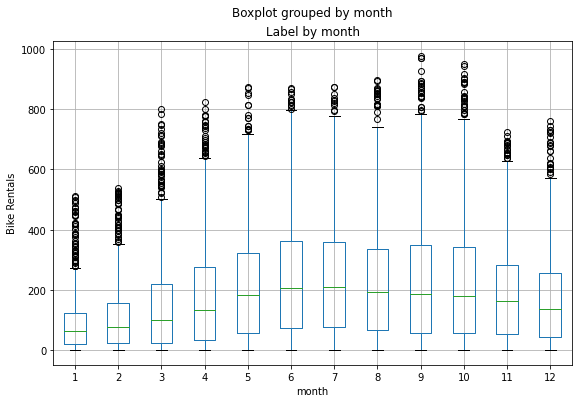

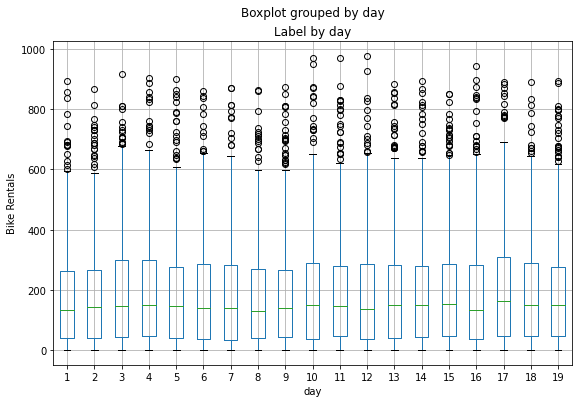

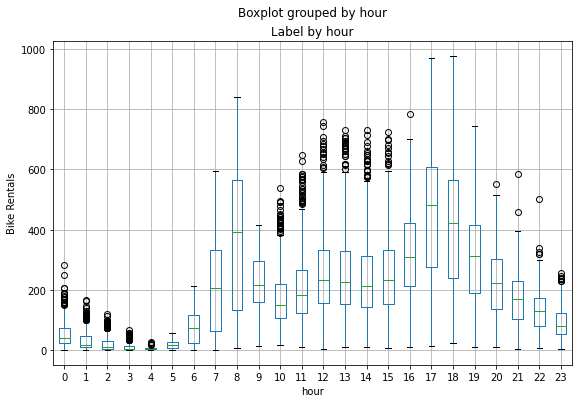

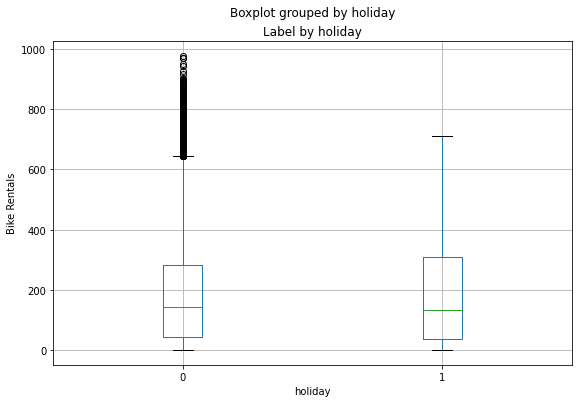

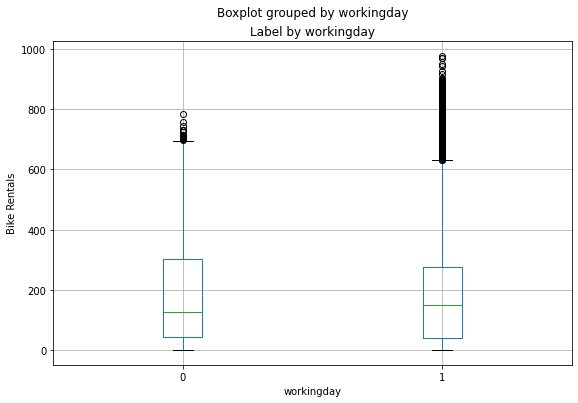

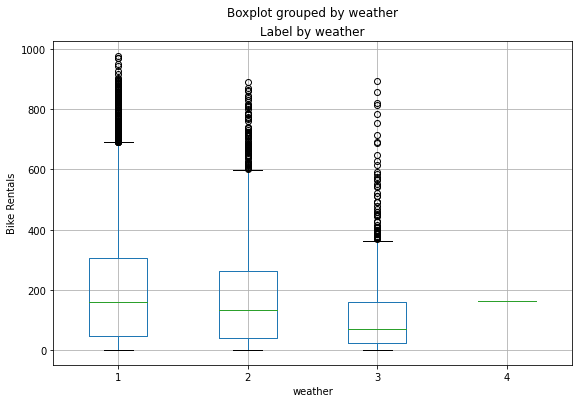

In [12]:
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    bike_data.boxplot(column = 'count', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Bike Rentals")
plt.show()

These results are discussed in the presentation.



##Normalize and standardize numeric data

In [13]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
bike_data[numeric_features] = min_max_scaler.fit_transform(bike_data[numeric_features])

In [14]:
numeric_features

['temp', 'atemp', 'humidity', 'windspeed']

In [15]:
bike_data

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,1,1,0,1,0,0,1,0.224490,0.305068,0.81,0.000000,16
1,0,1,1,1,1,0,0,1,0.204082,0.288064,0.80,0.000000,40
2,0,1,1,2,1,0,0,1,0.204082,0.288064,0.80,0.000000,32
3,0,1,1,3,1,0,0,1,0.224490,0.305068,0.75,0.000000,13
4,0,1,1,4,1,0,0,1,0.224490,0.305068,0.75,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,1,12,19,19,4,0,1,1,0.367347,0.423649,0.50,0.456213,336
10882,1,12,19,20,4,0,1,1,0.346939,0.372860,0.57,0.263195,241
10883,1,12,19,21,4,0,1,1,0.326531,0.338964,0.61,0.263195,168
10884,1,12,19,22,4,0,1,1,0.326531,0.372860,0.61,0.105325,129


In [16]:
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
bike_data[numeric_features] = standard_scaler.fit_transform(bike_data[numeric_features])

In [17]:
# Write the dataframe out to csv file for Sagemaker custom model
bike_data.to_csv (r'train_custom_alg.csv', index = False, header=True)

## Train Linear Regression Model

In [18]:
# Separate features and labels
X, y = bike_data[['year','season','month', 'hour', 'holiday','workingday','weather','temp', 'atemp', 'humidity', 'windspeed']].values, bike_data['count'].values
print('Features:',X[:10], '\nLabels:', y[:10], sep='\n')

Features:
[[ 0.          1.          1.          0.          0.          0.
   1.         -1.33366069 -1.09273697  0.99321305 -1.56775367]
 [ 0.          1.          1.          1.          0.          0.
   1.         -1.43890721 -1.18242083  0.94124921 -1.56775367]
 [ 0.          1.          1.          2.          0.          0.
   1.         -1.43890721 -1.18242083  0.94124921 -1.56775367]
 [ 0.          1.          1.          3.          0.          0.
   1.         -1.33366069 -1.09273697  0.68142998 -1.56775367]
 [ 0.          1.          1.          4.          0.          0.
   1.         -1.33366069 -1.09273697  0.68142998 -1.56775367]
 [ 0.          1.          1.          5.          0.          0.
   2.         -1.33366069 -1.27151467  0.68142998 -0.83244247]
 [ 0.          1.          1.          6.          0.          0.
   1.         -1.43890721 -1.18242083  0.94124921 -1.56775367]
 [ 0.          1.          1.          7.          0.          0.
   1.         -1.5441

In [19]:
from sklearn.model_selection import train_test_split

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 7620 rows
Test Set: 3266 rows


In [ ]:
######### skip this cell and following to avoid onehot encode
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor_cols = ColumnTransformer(
    transformers=[
        #('num', numeric_transformer, numeric_features), # standard scaling now in cell above
        ('cat', categorical_transformer, categorical_features)])


In [ ]:
### skip this cell and following commented out to avoid one-hot encoding
# Create a pipeline with the column transformer, note that
# more things can be added to this pipeline in the future
preprocessor = Pipeline(steps=[('preprocessor', preprocessor_cols)])
preprocessor.fit(X_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                                

In [ ]:
#X_train_hat = preprocessor.transform(X_train)

In [ ]:
#X_test_hat = preprocessor.transform(X_test)

In [ ]:
#X_train = X_train_hat

In [ ]:
#X_test = X_test_hat

In [20]:
# Train the model
from sklearn.linear_model import LinearRegression

# Fit a linear regression model on the training set
model = LinearRegression().fit(X_train, y_train)
print (model)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [21]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ' ,y_test[:10])

Predicted labels:  [319. 250. 246. 386. 296. 261. 298.  63. 257. 164.]
Actual labels   :  [244 239 229 467 335  40 329   2 141 391]


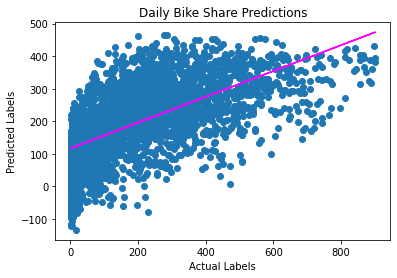

In [22]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2)

MAE 105.9048195112117
MSE: 19850.45449170164
RMSE: 140.89164095751613
R2: 0.38874421969900275


#Train a Lasso regression model

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False) 

MAE 105.53155836159792
MSE: 19863.885963451292
RMSE: 140.93929886107455
R2: 0.38833062389199713


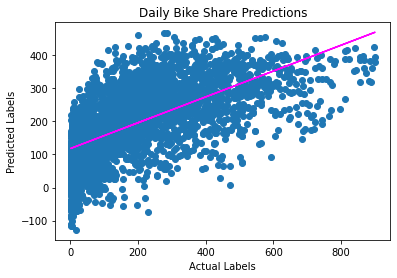

In [24]:
from sklearn.linear_model import Lasso

# Fit a lasso model on the training set
model = Lasso().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

# Train a Decison Tree algorithm

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

# Train the model
model = DecisionTreeRegressor().fit(X_train, y_train)
print (model, "\n")

# Visualize the model tree
tree = export_text(model)
print(tree)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best') 

|--- feature_3 <= 6.50
|   |--- feature_3 <= 5.50
|   |   |--- feature_3 <= 1.50
|   |   |   |--- feature_5 <= 0.50
|   |   |   |   |--- feature_2 <= 4.50
|   |   |   |   |   |--- feature_0 <= 0.50
|   |   |   |   |   |   |--- feature_2 <= 1.50
|   |   |   |   |   |   |   |--- feature_10 <= -0.10
|   |   |   |   |   |   |   |   |--- feature_9 <= 0.97
|   |   |   |   |   |   |   |   |   |--- feature_10 <= -1.02
|   |   |   |   |   |   |   |   |   |   |--- feature_9 <= -0.33
|   |   |   |   |   |   |   |   |   |   |   |--- value: [28.00]
|   |   |   |   |   |   |   |   |   |   |--- feature_9 

MAE 39.19289650949173
MSE: 4167.855939987752
RMSE: 64.55893385107713
R2: 0.8716590576883577


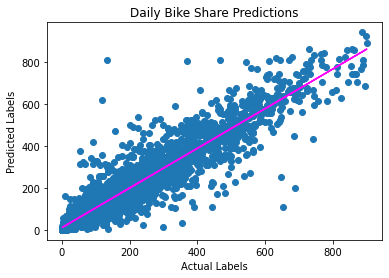

In [26]:
# Evaluate the model using the test data
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#Random Forest model

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False) 

MAE 28.970559990377044
MSE: 2123.482029828677
RMSE: 46.081254646859136
R2: 0.9346115392148482


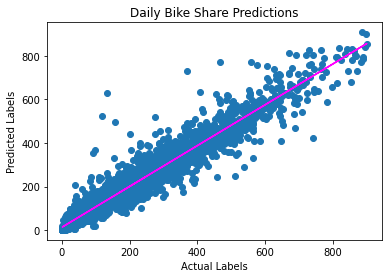

In [27]:
from sklearn.ensemble import RandomForestRegressor

# Train the model
model = RandomForestRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

# Gradient Boosting model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 

MAE 46.518124212106855
MSE: 4558.678314638814
RMSE: 67.51798511980948
R2: 0.8596244498320846


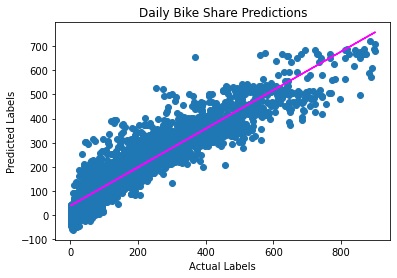

In [28]:
# Train the model
from sklearn.ensemble import GradientBoostingRegressor

# Fit a lasso model on the training set
model = GradientBoostingRegressor().fit(X_train, y_train)
print (model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

# Hyperparameter Tuning with Gradient Boosting

Best parameter combination: {'learning_rate': 0.5, 'n_estimators': 150} 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.5, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False) 

MAE 35.919528494633134
MSE: 2784.164143587747
RMSE: 52.76517927182421
R2: 0.914267130418287


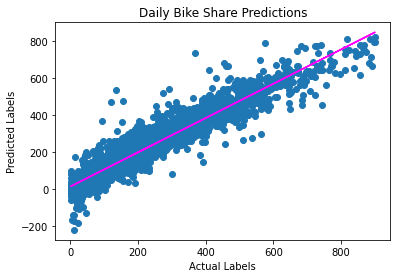

In [29]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model=gridsearch.best_estimator_
print(model, "\n")

# Evaluate the model using the test data
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#Pipeline for pre-processing (done above, so disabled)

In [30]:
# Train the model
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Define preprocessing for numeric columns (scale them)
numeric_features = [6,7,8,9]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [0,1,2,3,4,5]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[#('preprocessor', preprocessor),
                           ('regressor', GradientBoostingRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(memory=None,
         steps=[('regressor',
                 GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                           criterion='friedman_mse', init=None,
                                           learning_rate=0.1, loss='ls',
                                           max_depth=3, max_features=None,
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100,
                                           n_iter_no_change=None,
                                           presort='deprecated',
                                           random_state=N

MAE 46.52032463407497
MSE: 4556.654227017231
RMSE: 67.50299420779223
R2: 0.8596867776371757


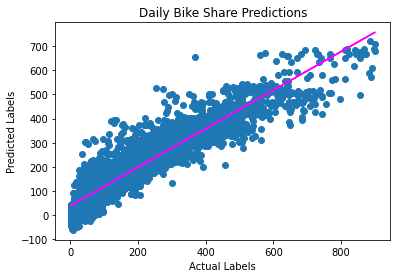

In [31]:
# Get predictions
predictions = model.predict(X_test)

# Display metrics
mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

#Use a Random Forest model with the pipeline

Pipeline(memory=None,
         steps=[('regressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False) 

MAE 29.016057431545793
MSE: 2128.056023736785
RMSE: 46.130857608945284
R2: 0.9344706920510434


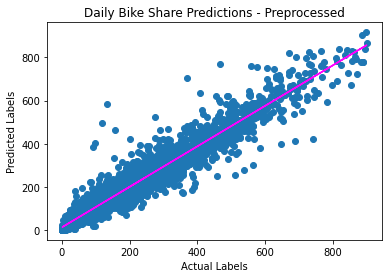

In [32]:
# Use a different estimator in the pipeline
pipeline = Pipeline(steps=[#('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model, "\n")

# Get predictions
predictions = model.predict(X_test)

# Display metrics
mae = mean_absolute_error(y_test, predictions)
print("MAE", mae)
mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)
r2 = r2_score(y_test, predictions)
print("R2:", r2)

# Plot predicted vs actual
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions - Preprocessed')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

# Preprocess Data for SageMaker Built-in Models



*   Move Label (rental count) to column 0
*   Remove unused columns (year, day, registered, casual)

*   Feature engineering: one-hot encode categorical
*   Split into train and test 70/30


*   Save to files









In [33]:
bike_data.head(10)

,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,0,1,1,0,1,0,0,1,-1.333661,-1.092737,0.993213,-1.567754,16
1,0,1,1,1,1,0,0,1,-1.438907,-1.182421,0.941249,-1.567754,40
2,0,1,1,2,1,0,0,1,-1.438907,-1.182421,0.941249,-1.567754,32
3,0,1,1,3,1,0,0,1,-1.333661,-1.092737,0.681430,-1.567754,13
4,0,1,1,4,1,0,0,1,-1.333661,-1.092737,0.681430,-1.567754,1
5,0,1,1,5,1,0,0,2,-1.333661,-1.271515,0.681430,-0.832442,1
6,0,1,1,6,1,0,0,1,-1.438907,-1.182421,0.941249,-1.567754,2
7,0,1,1,7,1,0,0,1,-1.544154,-1.271515,1.253032,-1.567754,3
8,0,1,1,8,1,0,0,1,-1.333661,-1.092737,0.681430,-1.567754,8
9,0,1,1,9,1,0,0,1,-0.912675,-0.735182,0.733394,-1.567754,14


In [34]:
bike_data.shape

(10886, 13)

In [35]:
label = 'count'

In [36]:
data = bike_data

In [37]:
# Rearrage the dataset columns
cols = data.columns.tolist()
cols

['year',
 'month',
 'day',
 'hour',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'count']

In [38]:
colIdx = data.columns.get_loc(label)
# Do nothing if the label is in the 0th position
# Otherwise, change the order of columns to move label to 0th position
if colIdx != 0:
    cols = cols[colIdx:colIdx+1] + cols[0:colIdx] + cols[colIdx+1:]
cols

['count',
 'year',
 'month',
 'day',
 'hour',
 'season',
 'holiday',
 'workingday',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed']

In [39]:
# Change the order of data so that label is in the 0th column
modified_data = data[cols]
modified_data

,count,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,16,0,1,1,0,1,0,0,1,-1.333661,-1.092737,0.993213,-1.567754
1,40,0,1,1,1,1,0,0,1,-1.438907,-1.182421,0.941249,-1.567754
2,32,0,1,1,2,1,0,0,1,-1.438907,-1.182421,0.941249,-1.567754
3,13,0,1,1,3,1,0,0,1,-1.333661,-1.092737,0.681430,-1.567754
4,1,0,1,1,4,1,0,0,1,-1.333661,-1.092737,0.681430,-1.567754
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,336,1,12,19,19,4,0,1,1,-0.596935,-0.467310,-0.617666,1.617227
10882,241,1,12,19,20,4,0,1,1,-0.702182,-0.735182,-0.253919,0.269704
10883,168,1,12,19,21,4,0,1,1,-0.807428,-0.913959,-0.046064,0.269704
10884,129,1,12,19,22,4,0,1,1,-0.807428,-0.735182,-0.046064,-0.832442


In [40]:
modified_data = modified_data.drop(columns='day')
modified_data

,count,year,month,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,16,0,1,0,1,0,0,1,-1.333661,-1.092737,0.993213,-1.567754
1,40,0,1,1,1,0,0,1,-1.438907,-1.182421,0.941249,-1.567754
2,32,0,1,2,1,0,0,1,-1.438907,-1.182421,0.941249,-1.567754
3,13,0,1,3,1,0,0,1,-1.333661,-1.092737,0.681430,-1.567754
4,1,0,1,4,1,0,0,1,-1.333661,-1.092737,0.681430,-1.567754
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,336,1,12,19,4,0,1,1,-0.596935,-0.467310,-0.617666,1.617227
10882,241,1,12,20,4,0,1,1,-0.702182,-0.735182,-0.253919,0.269704
10883,168,1,12,21,4,0,1,1,-0.807428,-0.913959,-0.046064,0.269704
10884,129,1,12,22,4,0,1,1,-0.807428,-0.735182,-0.046064,-0.832442


In [41]:
# One hot encode and fill missing values
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [42]:
# Remove label so that it is not encoded
data_without_label = modified_data.drop([label], axis=1)
#data_without_label

In [ ]:
############# Skip transforms to avoid one-hot-encode

In [ ]:
#numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [ ]:
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
numeric_features = data_without_label.select_dtypes(include=['int64','float64']).columns
numeric_features

Index(['year', 'month', 'hour', 'season', 'holiday', 'workingday', 'weather',
       'temp', 'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [ ]:
categorical_features = data_without_label.select_dtypes(exclude=['int64','float64']).columns
#categorical_features

In [ ]:
# for one-hot encode
#categorical_features = [1,2,3,4,5,6]

In [ ]:
# Create the column transformer
preprocessor_cols = ColumnTransformer(
    transformers=[#('num', numeric_transformer, numeric_features),
                  ('cat', categorical_transformer, categorical_features)])

In [ ]:
# Create a pipeline with the column transformer, note that
# more things can be added to this pipeline in the future
preprocessor = Pipeline(steps=[('preprocessor', preprocessor_cols)])
preprocessor.fit(data_without_label)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categories='auto',
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                                                                 sparse=True))],
                                                

In [ ]:
modified_data_without_label = preprocessor.transform(data_without_label)
modified_data_without_label

array([], shape=(10886, 0), dtype=float64)

In [43]:
#After skipping transforms
#############################
modified_data_without_label = data_without_label

In [44]:
if (type(modified_data_without_label) is not np.ndarray):
    #modified_data_without_label = modified_data_without_label.toarray()
    modified_data_without_label = modified_data_without_label.to_numpy()

In [45]:
modified_data_array = np.concatenate(
    (np.array(modified_data[label]).reshape(-1, 1),
     modified_data_without_label), axis=1)
#modified_data_array

In [46]:
# Save the processed file, please change preicison in fmt as needed
np.savetxt("sage_data_processed1.csv", modified_data_array, delimiter=",", fmt='%1.4f')

In [47]:
# Split the file into train and test (80% train and 20% test)
from sklearn.model_selection import train_test_split
train, test= train_test_split(modified_data_array, test_size=0.3)

In [48]:
# Save the train file, please change preicison in fmt as needed
np.savetxt("sage_train1.csv", train, delimiter=",", fmt='%1.4f')

# Save the test file, please change preicison in fmt as needed
np.savetxt("sage_test1.csv", test, delimiter=",", fmt='%1.4f')

In [49]:
train.shape

(7620, 12)

In [50]:
test.shape

(3266, 12)